In [1]:
!nvidia-smi

Mon Sep 20 10:07:01 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.63.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   73C    P8    73W / 149W |      0MiB / 11441MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
import os
import time
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F

from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torch.utils.data import random_split

from torchvision import transforms
from PIL import Image
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
from collections import Counter
import torchvision.models as models
from collections import OrderedDict
torch.autograd.set_detect_anomaly(True)
import copy
import datetime
import pytz

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
TEST_CSV_PATH = '/content/drive/MyDrive/CSE465/datasets/AgeDB/csv/AgeDB_final-with-solve-of-131-corrupted-files-all-classes.csv'
IMAGE_PATH_TEST = '/content/drive/MyDrive/CSE465/datasets/AgeDB/AgeDB-images-with-solved-corrupted-files/'

RANDOM_SEED = 42
PATH = '/content/drive/MyDrive/CSE465/Models_and_Logs/All-classes-Full-UTK-CORAL_ResNet34-100%-EPOCHS-200-withoutLRS'
NUM_CLASSES = 101
BATCH_SIZE = 256
GRAYSCALE = False
NUM_WORKERS = 0

In [5]:
# GPU or CPU
DEVICE = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

In [6]:
# Log File
if not os.path.exists(PATH): os.mkdir(PATH)
LOGFILE = os.path.join(PATH, 'evaluation_AgeDB.log')

In [7]:
header = []
timezone = pytz.timezone('Asia/Dhaka')
header.append(f'\n\n\nLast Run: {datetime.datetime.now(timezone)}')
header.append(f'PyTorch Version: {torch.__version__}')
header.append(f'CUDA device available: {torch.cuda.is_available()}')
header.append(f'Using CUDA device: {DEVICE}')
header.append(f'Random Seed: {RANDOM_SEED}')
header.append(f'NUM WORKERS: {NUM_WORKERS}')
header.append(f'Output Path: {PATH}')
header.append(f'-------------------HyperParameters---------------')
header.append(f'No. of Classes: {NUM_CLASSES}')
header.append(f'Batch size: {BATCH_SIZE}')
header.append(f'Grayscale: {GRAYSCALE}')
header.append(f'\n-------------------EVALUATION RESULTS---------------')

In [8]:
for entry in header:
  print(entry)




Last Run: 2021-09-20 16:07:04.154328+06:00
PyTorch Version: 1.9.0+cu102
CUDA device available: True
Using CUDA device: cuda
Random Seed: 42
NUM WORKERS: 0
Output Path: /content/drive/MyDrive/CSE465/Models_and_Logs/All-classes-Full-UTK-CORAL_ResNet34-100%-EPOCHS-200-withoutLRS
-------------------HyperParameters---------------
No. of Classes: 101
Batch size: 256
Grayscale: False

-------------------EVALUATION RESULTS---------------


In [9]:
with open(LOGFILE, 'a') as f:
    for entry in header:
        f.write(f'{entry}\n')
        f.flush()

# Dataset

In [10]:
df = pd.read_csv(TEST_CSV_PATH, index_col=1)
df

,file,label,label-CE
age,,,
1,1000_StephenHawking_1_m.jpg,1,0
3,1001_StephenHawking_3_m.jpg,3,2
3,1524_Bono_3_m.jpg,3,2
3,15958_MartinLutherKing_3_m.jpg,3,2
3,255_michaeljackson_3_m.jpg,3,2
...,...,...,...
98,1303_RitaLeviMontalcini_98_f.jpg,98,97
99,1304_RitaLeviMontalcini_99_f.jpg,99,98
100,10691_LuiseRainer_100_f.jpg,100,99


In [11]:
class AgeDBDataset(Dataset):
    """Custom Dataset for loading UTKFace face images"""

    def __init__(self, csv_path, img_dir, transform=None, items=None):
        df = pd.read_csv(csv_path)
        df['index'] = range(0, len(df))
        df = df.set_index('index')

        if items:
          # df=df[:items]
          # df=df[items:]
        self.img_dir = img_dir
        self.csv_path = csv_path
        self.img_names = df['file'].values
        # print(type(self.img_names))
        self.y = df['label'].values
        self.age = df['age'].values
        self.transform = transform

    def __getitem__(self, index):
        img = Image.open(os.path.join(self.img_dir, self.img_names[index]))
        img = img.convert('RGB')
        
        if self.transform is not None:
            img = self.transform(img)

        label = self.y[index]
        # levels = [1]*label + [0]*(NUM_CLASSES - 1 - label) #converting labels to levels..so if age is 22, 22 ones and (96-22) zeros
        levels = [1]*label + [0]*(NUM_CLASSES - label) #converting labels to levels..so if age is 22, 22 ones and (79-22) zeros, since total class is 101
        levels = torch.tensor(levels, dtype=torch.float32)

        return img, label, levels
        
    def __len__(self):
        return self.y.shape[0]

In [12]:
custom_transform_test = transforms.Compose([transforms.Resize((128, 128)),
                                        transforms.CenterCrop((120, 120)),
                                        transforms.ToTensor()])

test_dataset = AgeDBDataset(csv_path=TEST_CSV_PATH,
                              img_dir=IMAGE_PATH_TEST,
                              transform=custom_transform_test,
                              items = -1 # None
                            )

# Dataset Entity Distribution Analysis

In [13]:
def dataset_analysis(d):
  counter_label = Counter(np.sort(d.y))
  counter_age = Counter(np.sort(d.age))

  plt.scatter(counter_age.keys(), counter_age.values(), s=10, c='black')
  plt.xlabel('Ages')
  plt.ylabel('Num of images per Age')
  plt.title('Entity Distribution Analysis')
  plt.grid()
  plt.show()
  
  print("label\t\tAge\t\tCount")
  for (label, key, value) in zip(counter_label.keys(), counter_age.keys(), counter_age.values()):
    print(label,'\t\t',key,'\t\t', value)

  print(torch.from_numpy(d.age).bincount())
  print('length of the dataset is: ', len(d))

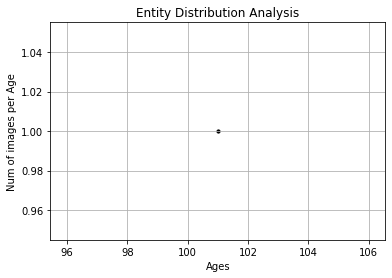

label		Age		Count
101 		 101 		 1
tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 1])
length of the dataset is:  1


In [14]:
dataset_analysis(test_dataset)

# Dataset Loader

In [15]:
test_loader = DataLoader(dataset=test_dataset,
                         batch_size=1, # BATCH_SIZE,
                         shuffle=False,
                         num_workers=NUM_WORKERS)

In [16]:
print(f"No. of Batches for AgeDB: {len(test_loader)}")

No. of Batches for AgeDB: 1


# Model

In [17]:
def conv3x3(in_planes, out_planes, stride=1):
    """3x3 convolution with padding"""
    return nn.Conv2d(in_planes, out_planes, kernel_size=3, stride=stride,
                     padding=1, bias=False)


class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, inplanes, planes, stride=1, downsample=None):
        super(BasicBlock, self).__init__()
        self.conv1 = conv3x3(inplanes, planes, stride)
        self.bn1 = nn.BatchNorm2d(planes)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = conv3x3(planes, planes)
        self.bn2 = nn.BatchNorm2d(planes)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        residual = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)

        if self.downsample is not None:
            residual = self.downsample(x)

        out += residual
        out = self.relu(out)

        return out


class ResNet(nn.Module):

    def __init__(self, block, layers, num_classes, grayscale):
        self.num_classes = num_classes
        self.inplanes = 64
        if grayscale:
            in_dim = 1
        else:
            in_dim = 3
        super(ResNet, self).__init__()
        self.conv1 = nn.Conv2d(in_dim, 64, kernel_size=7, stride=2, padding=3,
                               bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.layer1 = self._make_layer(block, 64, layers[0])
        self.layer2 = self._make_layer(block, 128, layers[1], stride=2)
        self.layer3 = self._make_layer(block, 256, layers[2], stride=2)
        self.layer4 = self._make_layer(block, 512, layers[3], stride=2)
        self.avgpool = nn.AvgPool2d(4)
        self.fc = nn.Linear(512, 1, bias=False)
        # self.linear_1_bias = nn.Parameter(torch.zeros(self.num_classes-1).float())
        self.linear_1_bias = nn.Parameter(torch.zeros(self.num_classes).float())

        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                n = m.kernel_size[0] * m.kernel_size[1] * m.out_channels
                m.weight.data.normal_(0, (2. / n)**.5)
            elif isinstance(m, nn.BatchNorm2d):
                m.weight.data.fill_(1)
                m.bias.data.zero_()

    def _make_layer(self, block, planes, blocks, stride=1):
        downsample = None
        if stride != 1 or self.inplanes != planes * block.expansion:
            downsample = nn.Sequential(
                nn.Conv2d(self.inplanes, planes * block.expansion,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(planes * block.expansion),
            )

        layers = []
        layers.append(block(self.inplanes, planes, stride, downsample))
        self.inplanes = planes * block.expansion
        for i in range(1, blocks):
            layers.append(block(self.inplanes, planes))

        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        x = x.view(x.size(0), -1)
        logits = self.fc(x)
        logits = logits + self.linear_1_bias
        probas = torch.sigmoid(logits)
        return logits, probas


def resnet34(num_classes, grayscale):
    """Constructs a ResNet-34 model."""
    model = ResNet(block=BasicBlock,
                   layers=[3, 4, 6, 3],
                   num_classes=num_classes,
                   grayscale=grayscale)
    return model

# Initialize Model, and Optimizer

In [18]:
torch.manual_seed(RANDOM_SEED)
torch.cuda.manual_seed(RANDOM_SEED)
model = resnet34(NUM_CLASSES, GRAYSCALE)

print(model)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

# Evaluation

In [19]:
def calculate_correct_preds(probas, targets):
  return torch.sum(torch.max(probas, dim = 1)[1] == targets)

In [20]:
def compute_acc(total_num_correct_preds, num_examples):
  return format((total_num_correct_preds/num_examples) * 100.0, '.3f')

In [21]:
def compute_mae_and_mse(model, data_loader, device):
  mae, mse, num_examples, total_num_correct_preds = 0., 0., 0, 0
  for i, (features, targets, levels) in enumerate(tqdm(data_loader)):
          
    targets, features = targets.to(device), features.to(device)
    logits, probas = model(features)
    # logits = logits + model.linear_1_bias
    # probas = torch.sigmoid(logits)
    print(probas)
    predict_levels = probas > 0.5
    print(predict_levels)

    predicted_labels = torch.sum(predict_levels, dim=1)
    print('Age: ',predicted_labels)
    num_correct_preds = torch.sum(predicted_labels == targets)
    total_num_correct_preds += num_correct_preds
    num_examples += targets.size(0)

    mae += torch.sum(torch.abs(predicted_labels - targets))
    mse += torch.sum((predicted_labels - targets)**2)

  print(f'total_num_correct_preds: {total_num_correct_preds}')
  acc = compute_acc(total_num_correct_preds, num_examples)
  mae = format(mae.float()/num_examples, '.3f')
  mse = format(torch.sqrt(mse.float()/num_examples), '.3f')      

  return mae, mse, acc

# Testing on AgeDB

In [22]:
list = [i for i in range(56,57)] # number epochs to evaluate
result_dict = {}

start_time = time.time()
test_mae = test_mse = test_acc = 0.0
for i in tqdm(list):
  model_name = f'Epoch_{i}_model.pt'
  model.load_state_dict(torch.load(os.path.join(PATH, model_name)))
  model.to(DEVICE)
  model.eval()

  with torch.set_grad_enabled(False):
    str0 = f'---------------{model_name}-----------------\n'
    print(str0)
    test_mae, test_mse, test_acc = compute_mae_and_mse(model, test_loader, device=DEVICE)
    
    result_dict[model_name] = test_mae    
    str1 = f'MAE/RMSE/ACC: | AGEDB-Test: {test_mae}/{test_mse}/{test_acc}%\n'
    str = str0+str1
    print(str1)
    with open(LOGFILE, 'a') as f: f.write(f'{str}\n')
    
time_elapsed = format((time.time() - start_time)/60, ".3f")
str = f'Time elapsed: {time_elapsed}mins\n'
print(str)
with open(LOGFILE, 'a') as f: f.write(f'{str}')

  0%|          | 0/1 [00:00<?, ?it/s]

---------------Epoch_56_model.pt-----------------



  0%|          | 0/1 [00:00<?, ?it/s]

tensor([[0.9934, 0.9931, 0.9930, 0.9929, 0.9928, 0.9928, 0.9927, 0.9927, 0.9926,
         0.9925, 0.9925, 0.9924, 0.9924, 0.9923, 0.9923, 0.9922, 0.9920, 0.9919,
         0.9918, 0.9917, 0.9915, 0.9913, 0.9909, 0.9905, 0.9894, 0.9882, 0.9817,
         0.9789, 0.9740, 0.9705, 0.9652, 0.9623, 0.9562, 0.9547, 0.9502, 0.9389,
         0.9314, 0.9264, 0.9203, 0.9149, 0.9027, 0.8994, 0.8921, 0.8876, 0.8845,
         0.8700, 0.8644, 0.8579, 0.8518, 0.8455, 0.8280, 0.8212, 0.8092, 0.7961,
         0.7762, 0.7609, 0.7476, 0.7423, 0.7280, 0.7238, 0.7096, 0.7024, 0.6970,
         0.6928, 0.6908, 0.6810, 0.6783, 0.6751, 0.6718, 0.6700, 0.6655, 0.6645,
         0.6617, 0.6599, 0.6590, 0.6551, 0.6536, 0.6529, 0.6512, 0.6507, 0.6475,
         0.6470, 0.6461, 0.6457, 0.6452, 0.6419, 0.6412, 0.6410, 0.6403, 0.6396,
         0.6380, 0.6379, 0.6377, 0.6376, 0.6376, 0.6374, 0.6371, 0.6371, 0.6371,
         0.6369, 0.6367]], device='cuda:0')
tensor([[True, True, True, True, True, True, True, True, True, Tr

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


In [23]:
result_list = sorted(result_dict.items(), key=lambda item:item[1])
with open(LOGFILE, 'a') as f:
    f.write(f'\n\n----Result in Sorted Order----\n\n')
    for item in result_list:
        str = item[0]+' '+item[1]+'\n'
        f.write(str)
        print(str)
        f.flush()

Epoch_56_model.pt 0.000

